In [7]:
# setup
%load_ext autoreload
%autoreload 2

# Import standard libraries   
import pandas as pd
import numpy as np
from joblib import dump

# Import custom data loader
from my_krml_25176165.data.sets import load_sets

y_train = y_train.squeeze() 
y_val = y_val.squeeze() 
y_test = y_test.squeeze() 
X_train = X_train.fillna(X_train.mean())
X_val = X_val.fillna(X_val.mean())
X_test = X_test.fillna(X_test.mean())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Create polynomial features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)

X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)

# print
print("X_train_poly shape:", X_train_poly.shape)

X_train_poly shape: (8864, 1890)


Exploratory Data Analysis (EDA)
Training set shape: (8864, 60)
Validation set shape: (2955, 60)
Test set shape: (2955, 60)
Number of features: 60


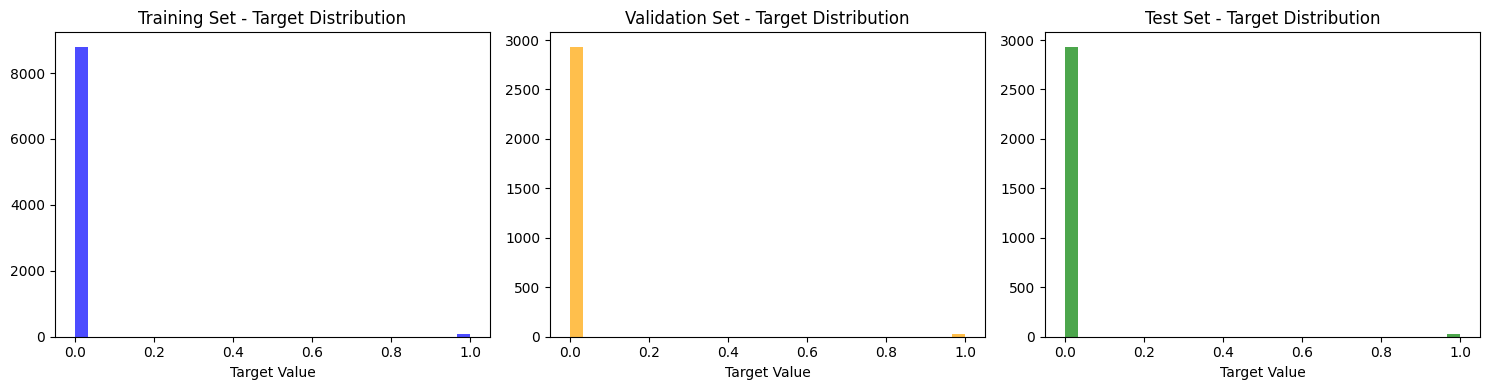

No missing values found!


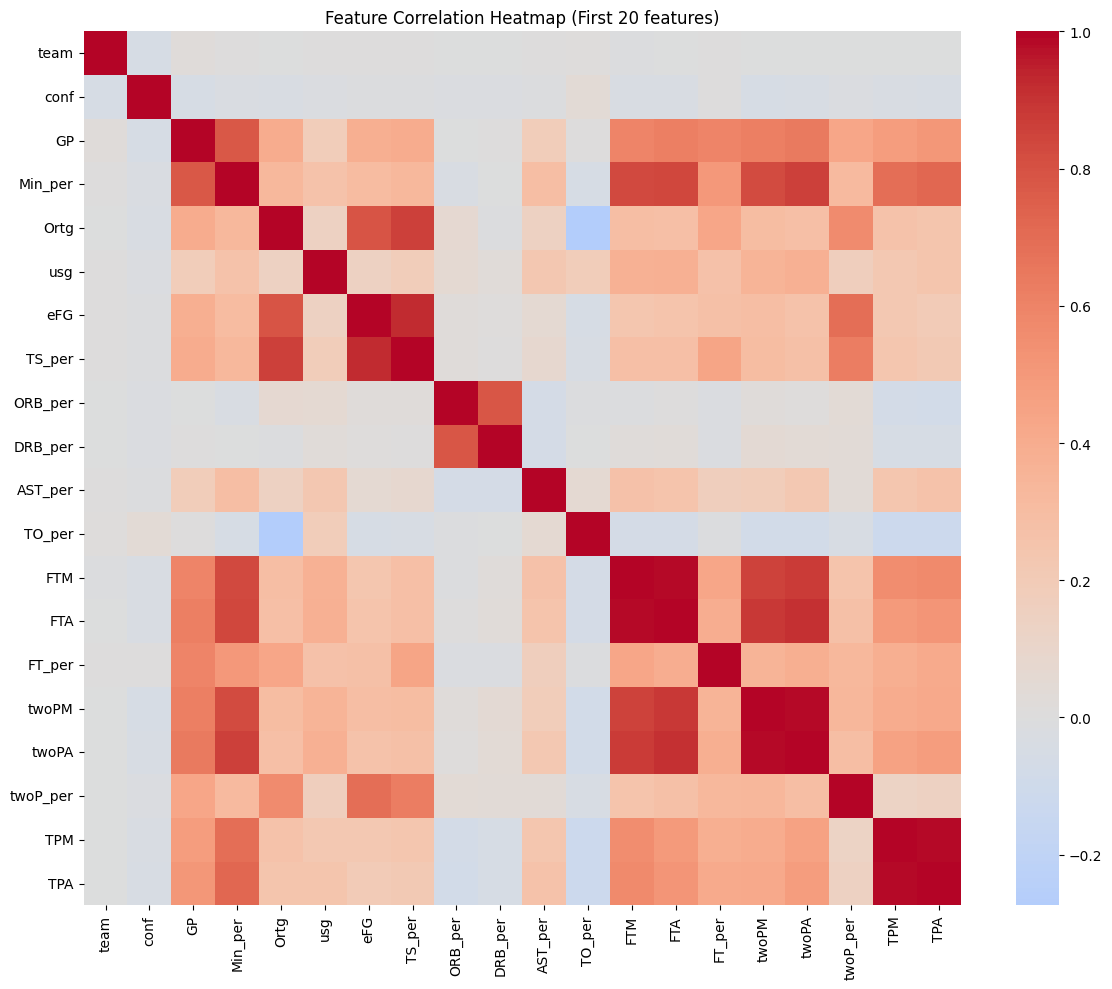

In [16]:
# EDA 

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')

print("="*50)
print("Exploratory Data Analysis (EDA)")
print("="*50)

# 1. Basic data information
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")  
print(f"Test set shape: {X_test.shape}")
print(f"Number of features: {X_train.shape[1]}")

# 2. Target variable distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(y_train, bins=30, alpha=0.7, color='blue')
axes[0].set_title('Training Set - Target Distribution')
axes[0].set_xlabel('Target Value')

axes[1].hist(y_val, bins=30, alpha=0.7, color='orange')  
axes[1].set_title('Validation Set - Target Distribution')
axes[1].set_xlabel('Target Value')

axes[2].hist(y_test, bins=30, alpha=0.7, color='green')
axes[2].set_title('Test Set - Target Distribution') 
axes[2].set_xlabel('Target Value')

plt.tight_layout()
plt.show()

# 3. Missing values analysis
missing_train = X_train.isnull().sum()
missing_features = missing_train[missing_train > 0]

if len(missing_features) > 0:
    plt.figure(figsize=(10, 6))
    missing_features.plot(kind='bar')
    plt.title('Missing Values by Feature')
    plt.xlabel('Features')
    plt.ylabel('Number of Missing Values')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No missing values found!")

# 4. Feature correlation heatmap (first 20 features to avoid overcrowding)
plt.figure(figsize=(12, 10))
corr_matrix = X_train.iloc[:, :20].corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap (First 20 features)')
plt.tight_layout()
plt.show()

In [10]:
# Apply Polynomial Transformation 

from sklearn.preprocessing import PolynomialFeatures
# Instantiate degree=2
poly = PolynomialFeatures(degree=2, include_bias=False)

# Fit on TRAIN only
X_train_poly = poly.fit_transform(X_train)

# Check shape
X_train_poly.shape

# Transform VAL / TEST
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test) 

# Train Linear Regression model Import linear regression 
from sklearn.linear_model import LinearRegression

# Instantiate
reg = LinearRegression()

# Fit model
reg.fit(X_train_poly, y_train)

# Save model
from joblib import dump
dump(reg, '../models/linear_poly_2.joblib')


['../models/linear_poly_2.joblib']

In [11]:
# Predict
y_train_preds = reg.predict(X_train_poly)
y_val_preds = reg.predict(X_val_poly)

# Import score function
from my_krml_25176165.models.performance import print_regressor_scores

# Train scores
print_regressor_scores(y_preds=y_train_preds, y_actuals=y_train, set_name='Training')

# Validation scores
print_regressor_scores(y_preds=y_val_preds, y_actuals=y_val, set_name='Validation')

# Test scores
y_test_preds = reg.predict(X_test_poly)
print_regressor_scores(y_preds=y_test_preds, y_actuals=y_test, set_name='Testing')


RMSE Training: 0.04484051510684136
MAE Training: 0.02343219306756537
RMSE Validation: 0.15703588808558266
MAE Validation: 0.07968939411448904
RMSE Testing: 0.0972617016782247
MAE Testing: 0.0468693219525805


In [12]:
# Add regularization to reduce overfitting
print("\n" + "="*50)
print("Improved version: using Ridge regularization")
print("="*50)


# Ridge regression model
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# # Find the optimal alpha using cross-validation
param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}
ridge_cv = GridSearchCV(Ridge(), param_grid, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train_poly, y_train)

print(f"Best alpha parameter: {ridge_cv.best_params_['alpha']}")

# Train the model with the best parameters
best_ridge = ridge_cv.best_estimator_
# Save the improved model
dump(best_ridge, '../models/ridge_poly_2.joblib')

# predict
y_train_preds_ridge = best_ridge.predict(X_train_poly)
y_val_preds_ridge = best_ridge.predict(X_val_poly)
y_test_preds_ridge = best_ridge.predict(X_test_poly)

# Evaluate the improved model
print("\n--- Ridge regularization results ---")
print_regressor_scores(y_preds=y_train_preds_ridge, y_actuals=y_train, set_name='Training (Ridge)')
print_regressor_scores(y_preds=y_val_preds_ridge, y_actuals=y_val, set_name='Validation (Ridge)')
print_regressor_scores(y_preds=y_test_preds_ridge, y_actuals=y_test, set_name='Testing (Ridge)')


Improved version: using Ridge regularization
Best alpha parameter: 100.0

--- Ridge regularization results ---
RMSE Training (Ridge): 0.05473945604660905
MAE Training (Ridge): 0.020919661884220668
RMSE Validation (Ridge): 0.0705896861125793
MAE Validation (Ridge): 0.02546604344536015
RMSE Testing (Ridge): 0.0744735962567526
MAE Testing (Ridge): 0.02619307011018167


In [13]:
# Model comparison
print("\n" + "="*50)
print("Model comparison")
print("="*50)


comparison_data = {
    'Model': ['Linear Regression', 'Ridge Regression'],
    'Training RMSE': [0.04484051510684136, np.sqrt(((y_train - y_train_preds_ridge)**2).mean())],
    'Validation RMSE': [0.15703588808558266, np.sqrt(((y_val - y_val_preds_ridge)**2).mean())],
    'Testing RMSE': [0.0972617016782247, np.sqrt(((y_test - y_test_preds_ridge)**2).mean())],
    'Overfitting Gap': [0.15703588808558266 - 0.04484051510684136, 
                       np.sqrt(((y_val - y_val_preds_ridge)**2).mean()) - np.sqrt(((y_train - y_train_preds_ridge)**2).mean())]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df)


Model comparison
               Model  Training RMSE  Validation RMSE  Testing RMSE  \
0  Linear Regression       0.044841         0.157036      0.097262   
1   Ridge Regression       0.054739         0.070590      0.074474   

   Overfitting Gap  
0         0.112195  
1         0.015850  



Model Performance Visualization Analysis


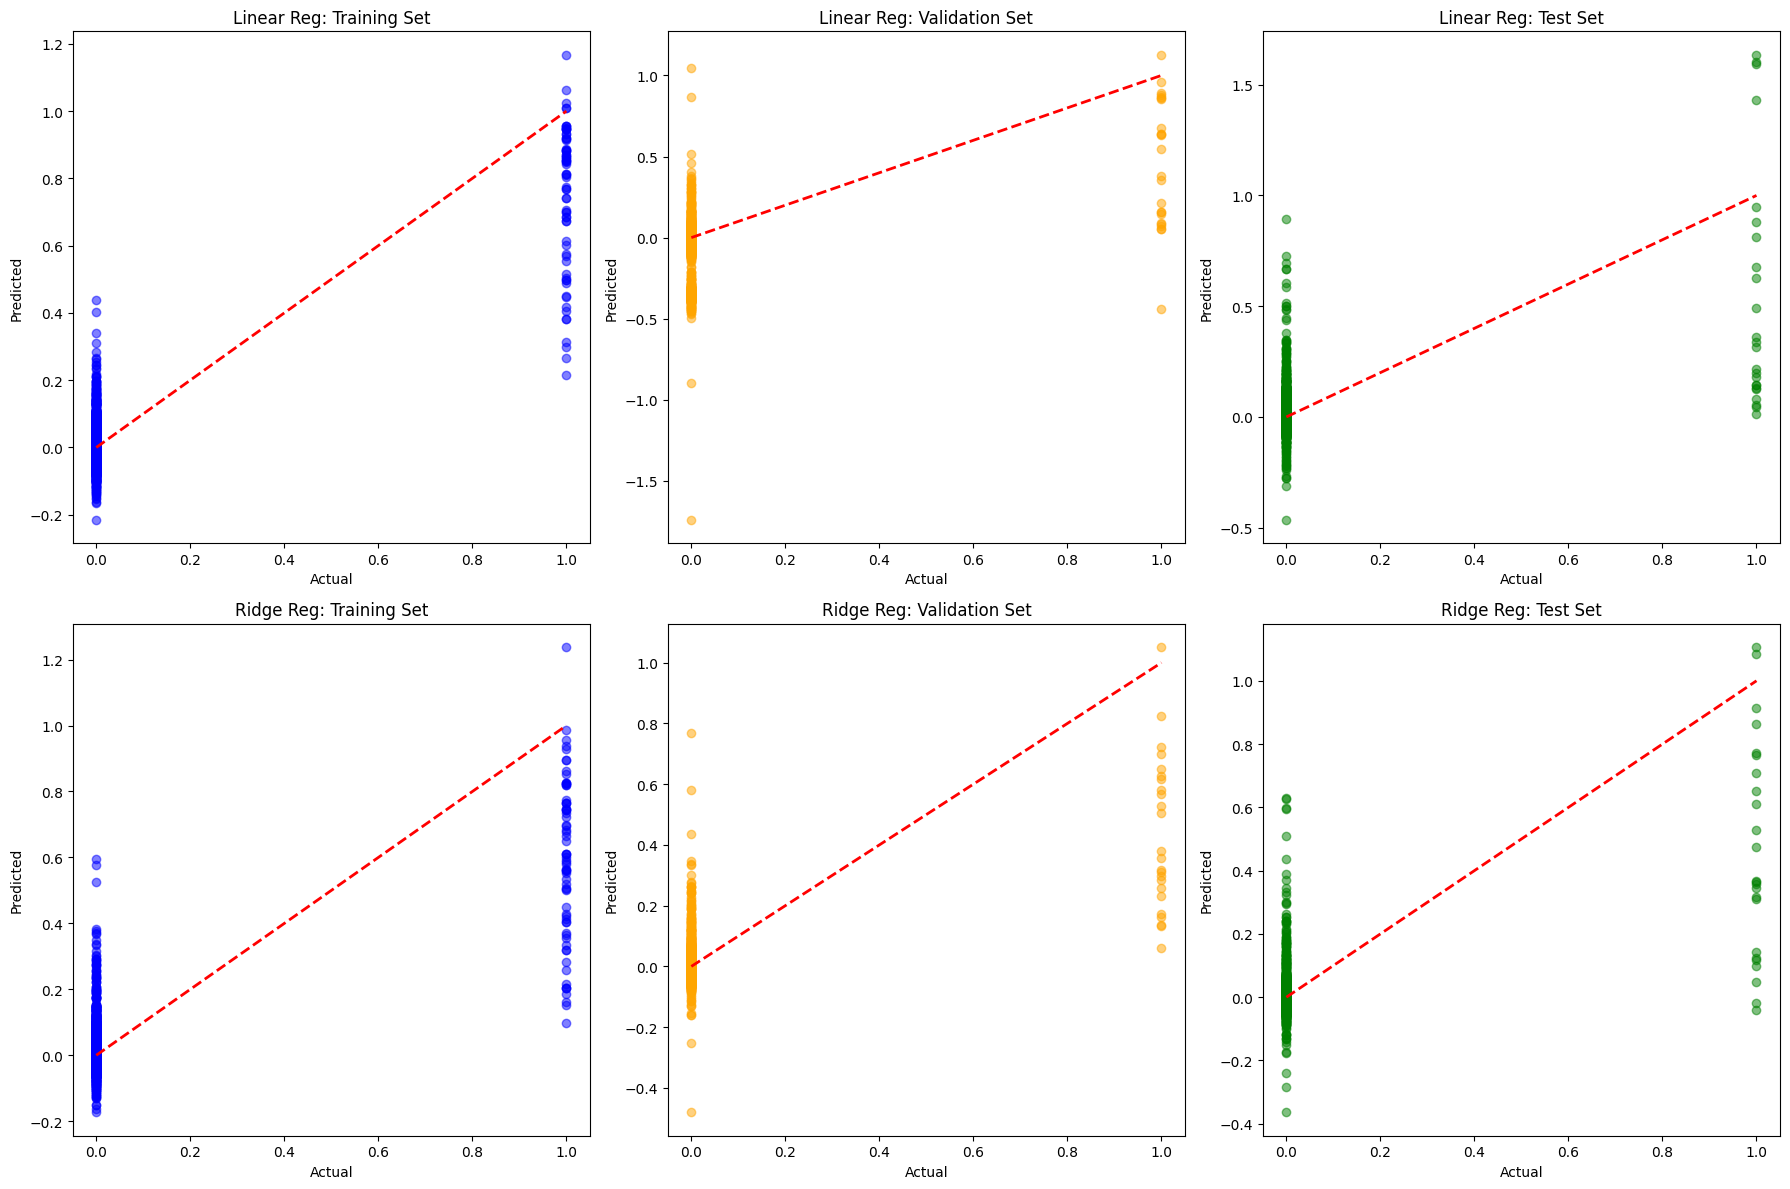

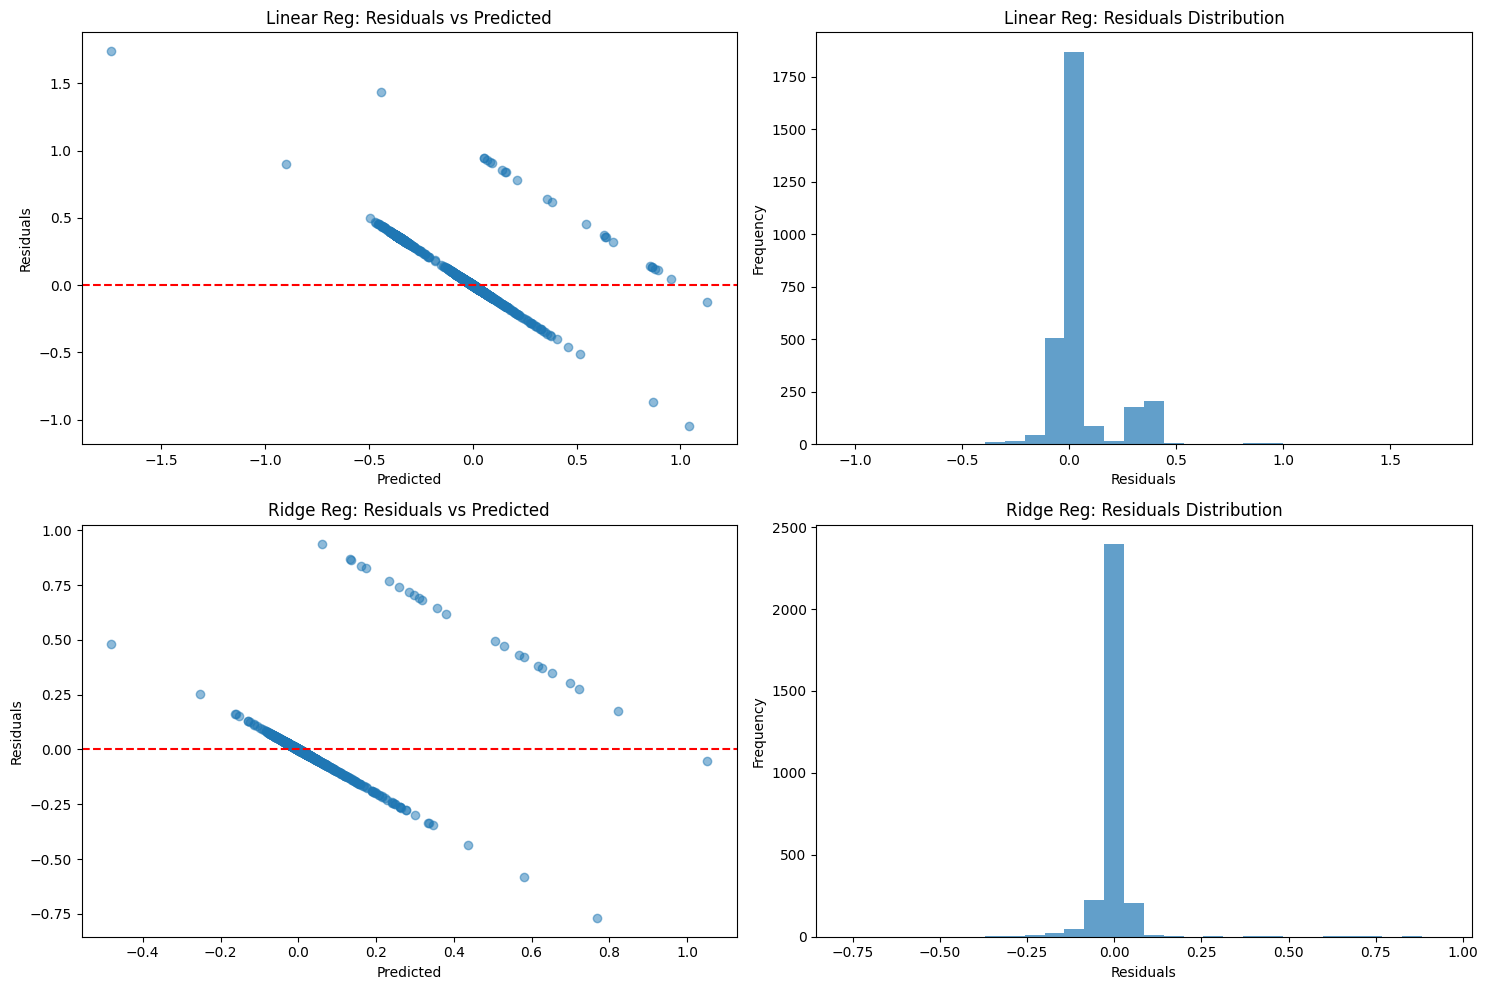

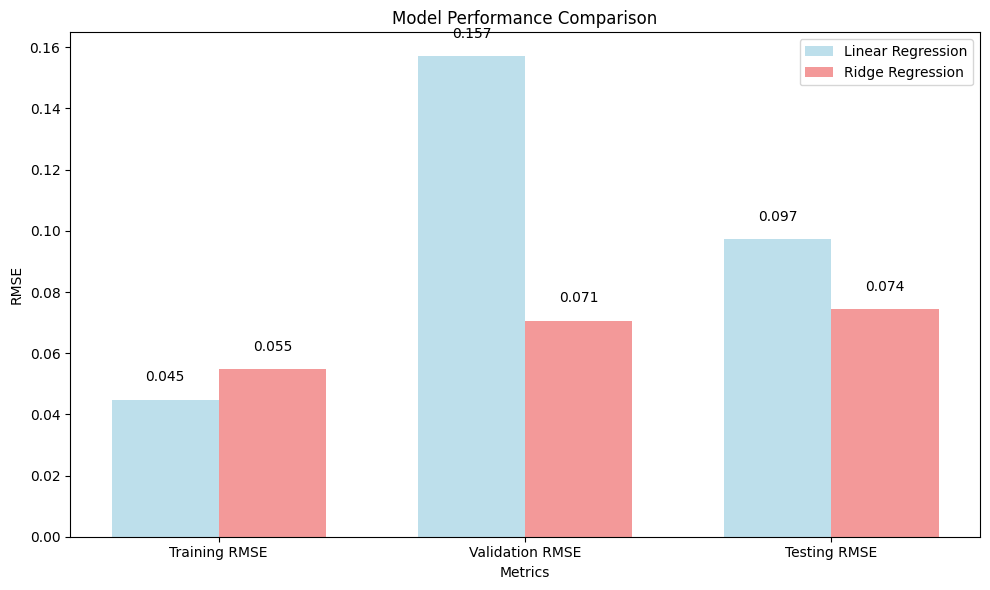

Visualization analysis completed!


In [17]:
# visualization

print("\n" + "="*50)
print("Model Performance Visualization Analysis")  
print("="*50)

# 1. Predicted vs Actual scatter plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Linear Regression
axes[0, 0].scatter(y_train, y_train_preds, alpha=0.5, color='blue')
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0, 0].set_title('Linear Reg: Training Set')
axes[0, 0].set_xlabel('Actual')
axes[0, 0].set_ylabel('Predicted')

axes[0, 1].scatter(y_val, y_val_preds, alpha=0.5, color='orange')
axes[0, 1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[0, 1].set_title('Linear Reg: Validation Set')
axes[0, 1].set_xlabel('Actual')
axes[0, 1].set_ylabel('Predicted')

axes[0, 2].scatter(y_test, y_test_preds, alpha=0.5, color='green')
axes[0, 2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 2].set_title('Linear Reg: Test Set')
axes[0, 2].set_xlabel('Actual')
axes[0, 2].set_ylabel('Predicted')

# Ridge Regression
axes[1, 0].scatter(y_train, y_train_preds_ridge, alpha=0.5, color='blue')
axes[1, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[1, 0].set_title('Ridge Reg: Training Set')
axes[1, 0].set_xlabel('Actual')
axes[1, 0].set_ylabel('Predicted')

axes[1, 1].scatter(y_val, y_val_preds_ridge, alpha=0.5, color='orange')
axes[1, 1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[1, 1].set_title('Ridge Reg: Validation Set')
axes[1, 1].set_xlabel('Actual')
axes[1, 1].set_ylabel('Predicted')

axes[1, 2].scatter(y_test, y_test_preds_ridge, alpha=0.5, color='green')
axes[1, 2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 2].set_title('Ridge Reg: Test Set')
axes[1, 2].set_xlabel('Actual')
axes[1, 2].set_ylabel('Predicted')

plt.tight_layout()
plt.show()

# 2. Residual analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Linear Regression residuals
residuals_linear_val = y_val - y_val_preds
axes[0, 0].scatter(y_val_preds, residuals_linear_val, alpha=0.5)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_title('Linear Reg: Residuals vs Predicted')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Residuals')

axes[0, 1].hist(residuals_linear_val, bins=30, alpha=0.7)
axes[0, 1].set_title('Linear Reg: Residuals Distribution')
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')

# Ridge Regression residuals  
residuals_ridge_val = y_val - y_val_preds_ridge
axes[1, 0].scatter(y_val_preds_ridge, residuals_ridge_val, alpha=0.5)
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].set_title('Ridge Reg: Residuals vs Predicted')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Residuals')

axes[1, 1].hist(residuals_ridge_val, bins=30, alpha=0.7)
axes[1, 1].set_title('Ridge Reg: Residuals Distribution')
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# 3. Model comparison bar chart
metrics_comparison = {
    'Training RMSE': [0.044841, 0.054739],
    'Validation RMSE': [0.157036, 0.070590], 
    'Testing RMSE': [0.097262, 0.074474]
}

x = np.arange(len(metrics_comparison))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
linear_bars = ax.bar(x - width/2, [metrics_comparison[key][0] for key in metrics_comparison], 
                     width, label='Linear Regression', alpha=0.8, color='lightblue')
ridge_bars = ax.bar(x + width/2, [metrics_comparison[key][1] for key in metrics_comparison], 
                    width, label='Ridge Regression', alpha=0.8, color='lightcoral')

ax.set_xlabel('Metrics')
ax.set_ylabel('RMSE')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics_comparison.keys())
ax.legend()

# Add value labels on bars
for i, (key, values) in enumerate(metrics_comparison.items()):
    ax.text(i - width/2, values[0] + 0.005, f'{values[0]:.3f}', ha='center', va='bottom')
    ax.text(i + width/2, values[1] + 0.005, f'{values[1]:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("Visualization analysis completed!")